Goal: create a model that predicts severity of a collision, based on the features of the collision

Create a balanced training set of data: look at just accidents happening in the middle of the night




In [1]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import RandomizedLasso
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


1) Load data  
    - 2014 attendant, vehicle, and casualty datasets
    - Description of data: https://drive.google.com/drive/u/0/folders/1afX9SJzqmO6rQG6FDhpMlzOfoy_NwI7Q
    - Merge on AREFNO
2) Train, Test split  
3) Hyper Paramter tuning for Random Forest Classifier  
3) Feature Importance  
4) Next: Visualize a decision tree  

** * Load Data * **

In [11]:
df_att = pd.read_csv('./data/2014-gla-data-extract-attendant.csv')
df_cas = pd.read_csv('./data/2014-gla-data-extract-casualty.csv')
df_veh = pd.read_csv('./data/2014-gla-data-extract-vehicle.csv')

df_crash = pd.merge(df_att, df_cas, on='AREFNO', how='inner')

df_crash = pd.merge(df_crash, df_veh, on='AREFNO', how='inner')

df_crash.Time = [int(x.strip("'")) for x in df_crash.Time]

df_crash['Accident Severity'].value_counts()

3 Slight     52331
2 Serious     3838
1 Fatal        237
Name: Accident Severity, dtype: int64

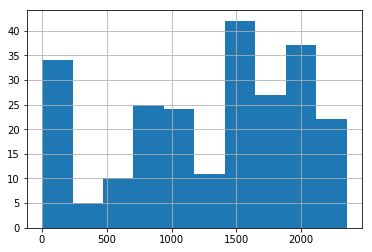

In [13]:
df_crash[df_crash['Accident Severity'] == '1 Fatal'].Time.hist()

In [20]:
df_crash = df_crash[df_crash.Time <= 500]

([array([ 736.,  155.,  423.,  106.,  344.,   59.,  308.,   93.,  234.,   50.]),
  array([ 847.,  190.,  478.,  114.,  359.,   63.,  358.,   97.,  257.,   51.]),
  array([ 856.,  190.,  491.,  114.,  372.,   63.,  359.,   98.,  259.,   51.])],
 array([   1. ,   50.9,  100.8,  150.7,  200.6,  250.5,  300.4,  350.3,
         400.2,  450.1,  500. ]),
 <a list of 3 Lists of Patches objects>)

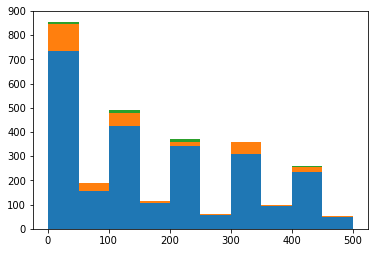

In [22]:
pl.figure()
x1 = df_crash[df_crash['Accident Severity'] == '3 Slight'].Time
x2 = df_crash[df_crash['Accident Severity'] == '2 Serious'].Time
x3 = df_crash[df_crash['Accident Severity'] == '1 Fatal'].Time
pl.hist([x1,x2,x3], stacked=True)


***2) Train, Test split  ***

- repeat the samples in the smallest class --> repeat the observations from the smallest (just do it with the training set) -- to rebalance (maybe add in cross validation)
- accuracy 
    -- how much better than the naive baselines (predict all one class)
    -- print confusion matrix (to visuzliae imbalanced problems)

In [23]:
# Select X and y data

y = df_crash['Accident Severity']

X = df_crash[[
    'Day', 'Time', 'Highway',
       'Road Class 1', 'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 'Road Class 2', 
       'Ped. Crossing Decoded', 'Light Conditions (Banded)', 'Weather',
       'Road Surface', 'Special Conditions', 'C/W Hazard', 'Casualty Class',
       'No. of Casualties', 'Ped. Location',
       'Ped. Movement', 'Mode of Travel', 'Vehicle Type',
        'Vehicle Type (Banded)',
       'Vehicle Manoeuvres', 'Vehicle Skidding', 'Restricted Lane',
       'Junction Location', 'Object in C/W', 'Veh. Leaving C/W',
       'Veh. off C/W','VJNYPURP DECODED']]

print ('X shape: ', X.shape)
print ('y shape: ', y.shape)

X=pd.get_dummies(X)
print ('X shape: ', X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0, stratify=y)

print ('\n shape')
print ('X: train, test', X_train.shape, X_test.shape, '\n')
print ('y: train, test', y_train.shape, y_test.shape)

X shape:  (2853, 30)
y shape:  (2853,)
X shape:  (2853, 187)

 shape
X: train, test (1711, 187) (1142, 187) 

y: train, test (1711,) (1142,)


*** 3) Balancing samples in training set ***

Code taken from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

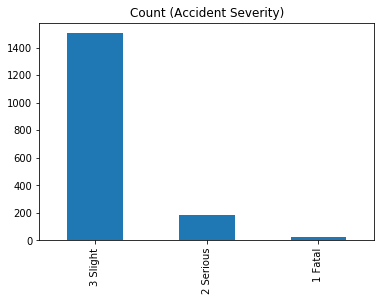

In [24]:
df_train = X.loc[X_train.index]
df_train['Accident Severity'] = y[y_train.index]
df_train['Accident Severity'].value_counts().plot(kind='bar', title='Count (Accident Severity)');

In [25]:
# Class count
count_class_3, count_class_2, count_class_1 = df_train['Accident Severity'].value_counts()

# Divide by class
df_class_3 = df_train[df_train['Accident Severity'] == '3 Slight']
df_class_2 = df_train[df_train['Accident Severity'] == '2 Serious']
df_class_1 = df_train[df_train['Accident Severity'] == '1 Fatal']

Random over-sampling:
2 Serious    1504
1 Fatal      1504
3 Slight     1504
Name: Accident Severity, dtype: int64


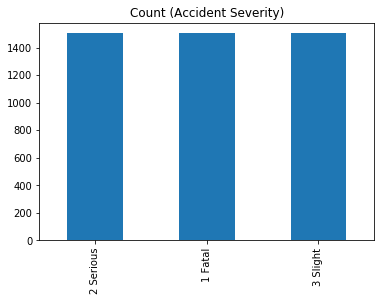

In [26]:
df_class_1_over = df_class_1.sample(count_class_3, replace=True) #take the number of fatal accidents as slight
df_class_2_over = df_class_2.sample(count_class_3, replace=True)
df_train_over = pd.concat([df_class_3, df_class_2_over, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over['Accident Severity'].value_counts())

df_train_over['Accident Severity'].value_counts().plot(kind='bar', title='Count (Accident Severity)');

In [27]:
# split df_train into X and y

y_train_over = df_train_over['Accident Severity']

X_train_over = df_train_over.drop(['Accident Severity'], axis=1)


print ('X shape: ', X_train_over.shape)
print ('y shape: ', y_train_over.shape)



X shape:  (4512, 187)
y shape:  (4512,)


*** Random Forest Modeling ***

In [28]:
#Naive predictor accuracy

len(y_test[y_test == '3 Slight'])/ len(y_test)*100.00


87.91593695271453

In [29]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)

rf=rf.fit(X_train_over,y_train_over)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 91.86


Confusion matrix:
 [[  7   1   8]
 [  0  51  71]
 [  0  13 991]]


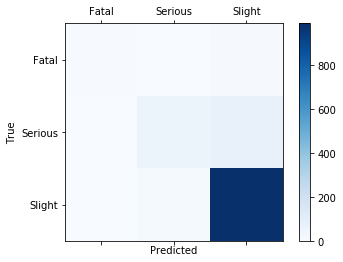

In [30]:
# COnfusion matrix code

y_pred = rf.predict(X_test)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=['1 Fatal', '2 Serious', '3 Slight'])
print('Confusion matrix:\n', conf_mat)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [31]:
count_cls_3, count_cls_2, count_cls_1 =y_test.value_counts()

conf_mat_pct = (np.array(conf_mat.T / np.array([count_cls_1, count_cls_2, count_cls_3])).T)*100.00

Confusion matrix, (%):
 [[ 43.75         6.25        50.        ]
 [  0.          41.80327869  58.19672131]
 [  0.           1.29482072  98.70517928]]


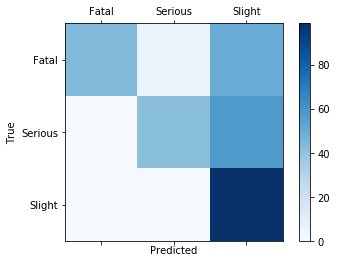

In [32]:
print('Confusion matrix, (%):\n', conf_mat_pct)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_pct, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

***4) Feature Importance  ***

Random Forest Feature ranking:          0                                                1
0   0.0853                                             Time
1   0.0372       Ped. Crossing Decoded_4 Pelican Or Similar
2   0.0242                                    Day_Saturday 
3   0.0234                                    Highway_3 Bor
4   0.0233          Vehicle Manoeuvres_18 Going Ahead Other
5   0.0213  Ped. Crossing Decoded_0 No Xing Facility In 50m
6   0.0206                                    Day_Sunday   
7   0.0195                   Road Class 2_-2 Not Applicable
8   0.0195                                   Highway_1 TLRN
9   0.0186               Mode of Travel_3 Powered 2 Wheeler
10  0.0181                  Junction Detail_0 No Jun In 20m
11  0.0176                   Junction Location_0 Not At Jct
12  0.0169                      Junction Location_8 Jct Mid
13  0.0161                     Mode of Travel_2 Pedal Cycle
14  0.0158                             Mode of Travel_4 Car


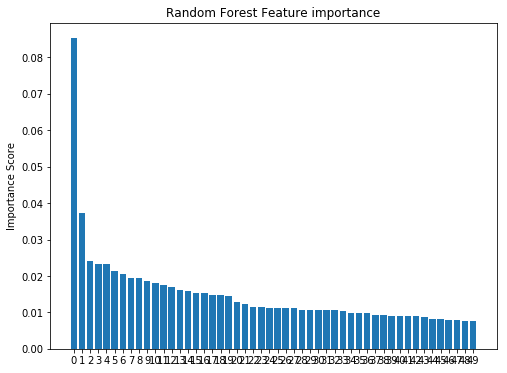

In [35]:
names = X_train_over.columns
feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
feat_num=50

pl.figure(figsize=(8,6))
pl.title("Random Forest Feature importance")
pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
pl.xticks(np.arange(feat_num))
pl.ylabel('Importance Score')

print("Random Forest Feature ranking:", pd.DataFrame(feat_sort)[:15])

*** Redo Sampling with under sampling of Slight samples ***

Random over-sampling:
1 Fatal      184
2 Serious    184
3 Slight     184
Name: Accident Severity, dtype: int64
X shape:  (552, 187)
y shape:  (552,)


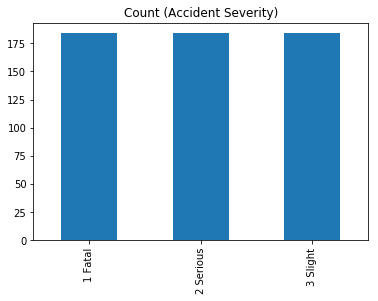

In [36]:
df_class_1_over = df_class_1.sample(count_class_2, replace=True) #take the number of fatal accidents as slight
df_class_3_under = df_class_3.sample(count_class_2, replace=True)
df_train_over_under = pd.concat([df_class_3_under, df_class_2, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over_under['Accident Severity'].value_counts())

df_train_over_under['Accident Severity'].value_counts().plot(kind='bar', title='Count (Accident Severity)');

# split df_train into X and y

y_train_over_under = df_train_over_under['Accident Severity']

X_train_over_under = df_train_over_under.drop(['Accident Severity'], axis=1)


print ('X shape: ', X_train_over_under.shape)
print ('y shape: ', y_train_over_under.shape)


In [37]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)

rf=rf.fit(X_train_over_under,y_train_over_under)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))

Accuracy: 75.83


Confusion matrix:
 [[ 11   3   2]
 [  0 105  17]
 [  5 249 750]]


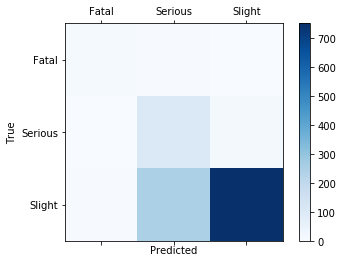

In [38]:
# COnfusion matrix code 

y_pred = rf.predict(X_test)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=['1 Fatal', '2 Serious', '3 Slight'])
print('Confusion matrix:\n', conf_mat)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
count_cls_3, count_cls_2, count_cls_1 =y_test.value_counts()

conf_mat_pct = (np.array(conf_mat.T / np.array([count_cls_1, count_cls_2, count_cls_3])).T)*100.00

Confusion matrix, (%):
 [[ 68.75        18.75        12.5       ]
 [  0.          86.06557377  13.93442623]
 [  0.49800797  24.80079681  74.70119522]]


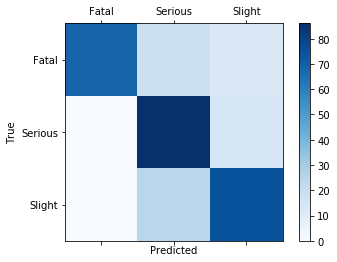

In [40]:
print('Confusion matrix, (%):\n', conf_mat_pct)

labels = ['Fatal', 'Serious', 'Slight']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_pct, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Random Forest Feature ranking:          0                                                1
0   0.0791                                             Time
1   0.0386       Ped. Crossing Decoded_4 Pelican Or Similar
2   0.0234                   Road Class 2_-2 Not Applicable
3   0.0219                                    Highway_3 Bor
4   0.0214                                    Day_Sunday   
5   0.0201          Vehicle Manoeuvres_18 Going Ahead Other
6   0.0200               Mode of Travel_3 Powered 2 Wheeler
7   0.0197  Ped. Crossing Decoded_0 No Xing Facility In 50m
8   0.0197                                    Day_Saturday 
9   0.0184                             Mode of Travel_4 Car
10  0.0184                      Junction Location_8 Jct Mid
11  0.0169                                   Road Class 1_A
12  0.0169         Junction Control_4 Give Way/Uncontrolled
13  0.0165                 Veh. Leaving C/W_0 Did Not Leave
14  0.0161                                   Highway_1 TLRN


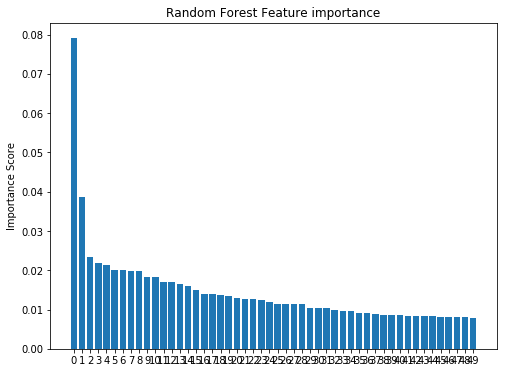

In [41]:
names = X_train_over_under.columns
feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
feat_num=50

pl.figure(figsize=(8,6))
pl.title("Random Forest Feature importance")
pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
pl.xticks(np.arange(feat_num))
pl.ylabel('Importance Score')

print("Random Forest Feature ranking:", pd.DataFrame(feat_sort)[:15])